# New York City Parking Ticket Analysis
## Table of Content
### 1. Overview - Distribution of parking tickets issued over the fiscal year.
### 2. Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month
### 3. Total Ticket Issued on Different Hours of the Day
### 4. Tickets Issued for Different Plate Types
#### 4.1 violation code with Plate Types

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline 

##### Preparation: Raw_data loading

In [3]:
#set fiscal year
year = 2015
filename = "Parking_Violations_Issued_-_Fiscal_Year_" + str(year) + ".csv"
print("loading data --- ", filename, "...")
raw_data = pd.read_csv(filename, low_memory = False)
print("done!")

loading data ---  Parking_Violations_Issued_-_Fiscal_Year_2015.csv ...
done!


In [4]:
#NYC fiscal year starts from July to June next year
start_date = str(year-1) + "-07-01"
end_date = str(year) + "-06-30"

#### 1. Overview - Distribution of parking tickets issued over the fiscal year.

Text(2015-06-30, 31333.45205479452, 'Annual Average')

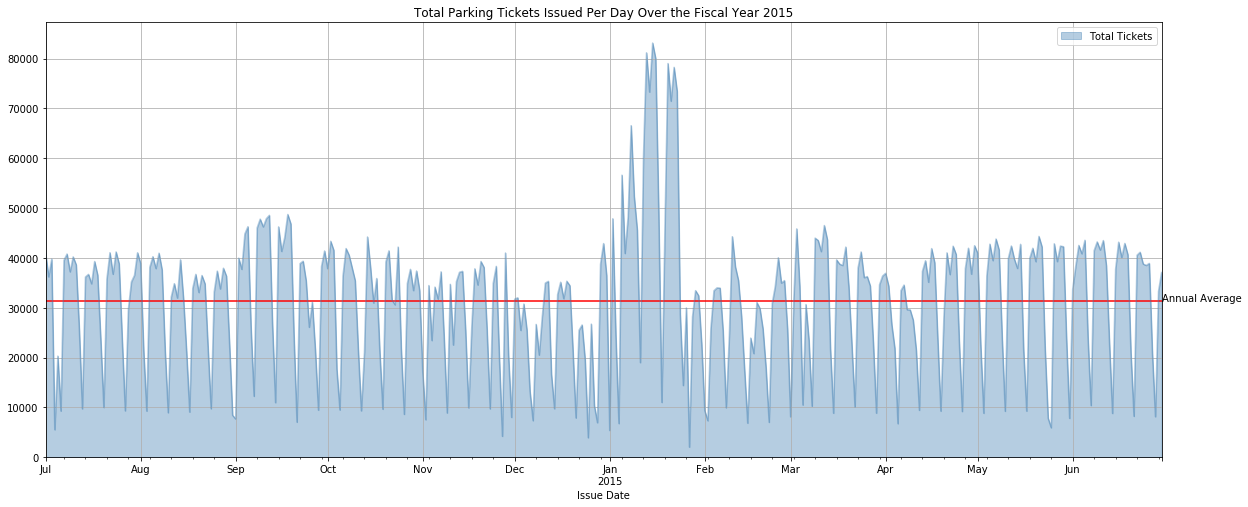

In [5]:
# Select the Columns with 'Issue Date' and 'Summons Number'
Date_SNum = raw_data[['Issue Date','Summons Number']]
# group the data by dates and count the total number of issued tickets on that date
Date_SNum = Date_SNum.groupby('Issue Date', as_index = False).count()
#Change the Issue Date to datetime objects
Date_SNum['Issue Date'] = pd.to_datetime(Date_SNum['Issue Date'])
#set Issue Date column as index column
Date_SNum = Date_SNum.set_index('Issue Date')
#Select the tickets issued inside the fiscal year range
Date_SNum = Date_SNum.loc[start_date : end_date]
#sort data from start_date to end_date
Date_SNum = Date_SNum.sort_index()
#rename the Summons Number to Total Tickets, rename the dataframe too
Date_Total = Date_SNum.rename(columns = {"Summons Number" : "Total Tickets"})

#Graph Section
fig1 = plt.figure(figsize = (20,8))
ax1 = fig1.add_subplot(1,1,1)
Date_Total.plot(ax = ax1, kind = 'area', color = 'steelblue', alpha = 0.4, grid = True)
plt.title("Total Parking Tickets Issued Per Day Over the Fiscal Year " + str(year) )
ax1.hlines(y = Date_Total['Total Tickets'].mean(), xmin = start_date, xmax = end_date, color = 'r', )
plt.text(end_date, Date_Total['Total Tickets'].mean(), "Annual Average")

#### 2. Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month

Text(0.5, 1.0, 'Distribution of the Traffic Tickets Issued on Each Month')

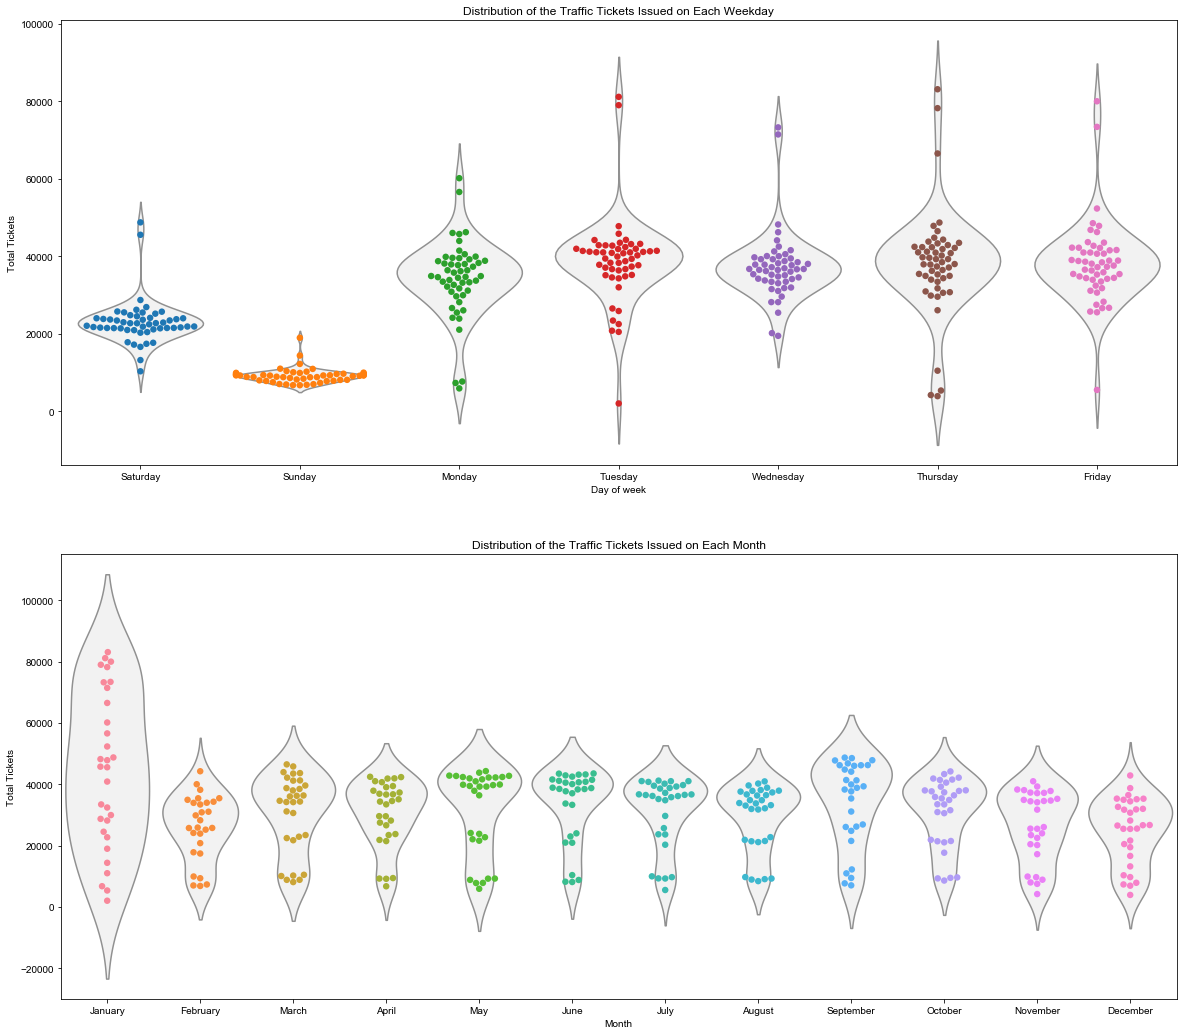

In [6]:
Date_Total["Day of week"] = Date_Total.index.day_name()
Date_Total["Month"] = Date_Total.index.month_name()

fig2, axes = plt.subplots(2,1, figsize = (20,18))
sns.set_style("dark")
#violin plot for the number of tickets gave out on each weekday
sns.violinplot(ax = axes[0], x = "Day of week", y = "Total Tickets", data = Date_Total, height = 5, width = 0.8, aspect = 13/5, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], scale = 'count', inner = None, color = "0.95")
sns.swarmplot(ax = axes[0], x = "Day of week", y = "Total Tickets", data = Date_Total, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], size = 6.5)
axes[0].set_title('Distribution of the Traffic Tickets Issued on Each Weekday')

#violin plot for the number of tickets gave out on each weekday
sns.violinplot(ax = axes[1], x = "Month", y = "Total Tickets", data = Date_Total, height = 5, width = 0.9, aspect = 13/5, order = ["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], scale = "count", inner = None, color = "0.95")
sns.swarmplot(ax = axes[1], x = "Month", y = "Total Tickets", data = Date_Total, order = ["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], size = 6.5)
axes[1].set_title('Distribution of the Traffic Tickets Issued on Each Month')

#### 3. Total Ticket Issued on Different Hours of the Day

Text(0.5, 1.0, ' Total Ticket Issued on Different Hours of the Day in Fiscal Year 2015')

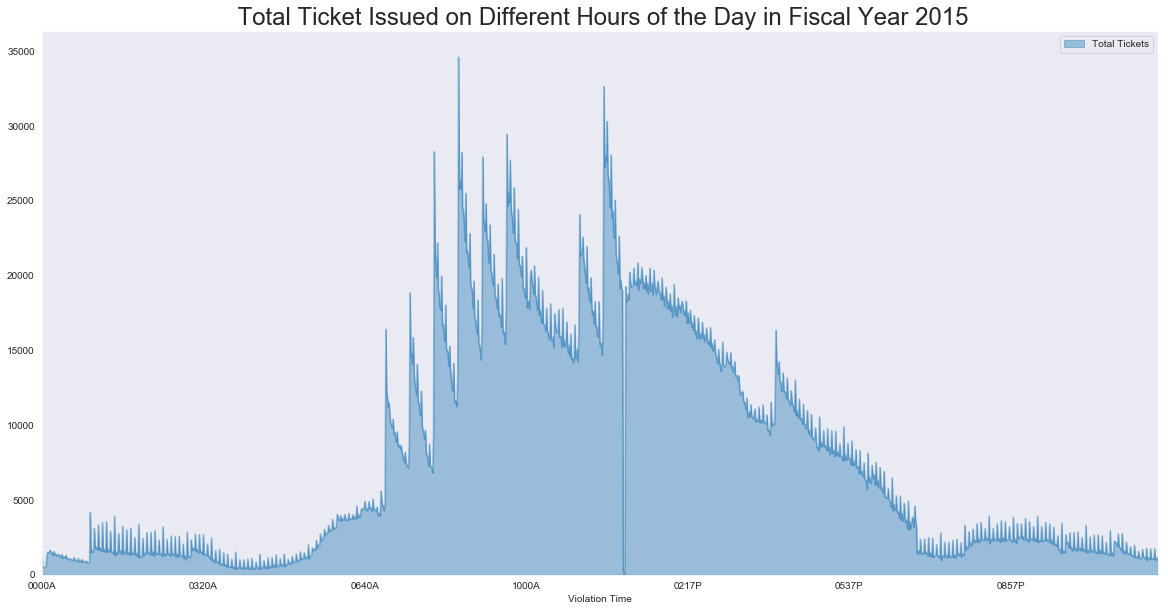

In [7]:
hour_data = raw_data.groupby('Violation Time', as_index = False).count()

hour_data = hour_data[['Violation Time', 'Summons Number']]

#Cleanning the dataset
hour_data = hour_data.loc[hour_data['Summons Number'] > 10]
hour_data = hour_data.rename(columns = {'Summons Number' : 'Total Tickets'})
hour_data_am = hour_data[hour_data['Violation Time'].str.contains('A')]
hour_data_pm = hour_data[hour_data['Violation Time'].str.contains('P')]
hour_data_am = hour_data_am.sort_values('Violation Time').set_index('Violation Time')
hour_data_pm = hour_data_pm.sort_values('Violation Time').set_index('Violation Time')

hour_data_am = hour_data_am['0000A':'1159A']
hour_data_pm = hour_data_pm['0000P':'1159P']

hour_data_cleaned = pd.concat([hour_data_am, hour_data_pm])

#Total Ticket Issued on Different Hours of the Day plot
fig, ax = plt.subplots(1, 1, figsize = (30,15))
hour_data_cleaned.plot(ax = ax, kind = 'area', figsize = (20,10), alpha = 0.4)
ax.set_title(" Total Ticket Issued on Different Hours of the Day in Fiscal Year " + str(year), Fontsize = 24)


### 4. Tickets Issued for Different Plate Types

Text(205.0, 0.5, 'Month Number')

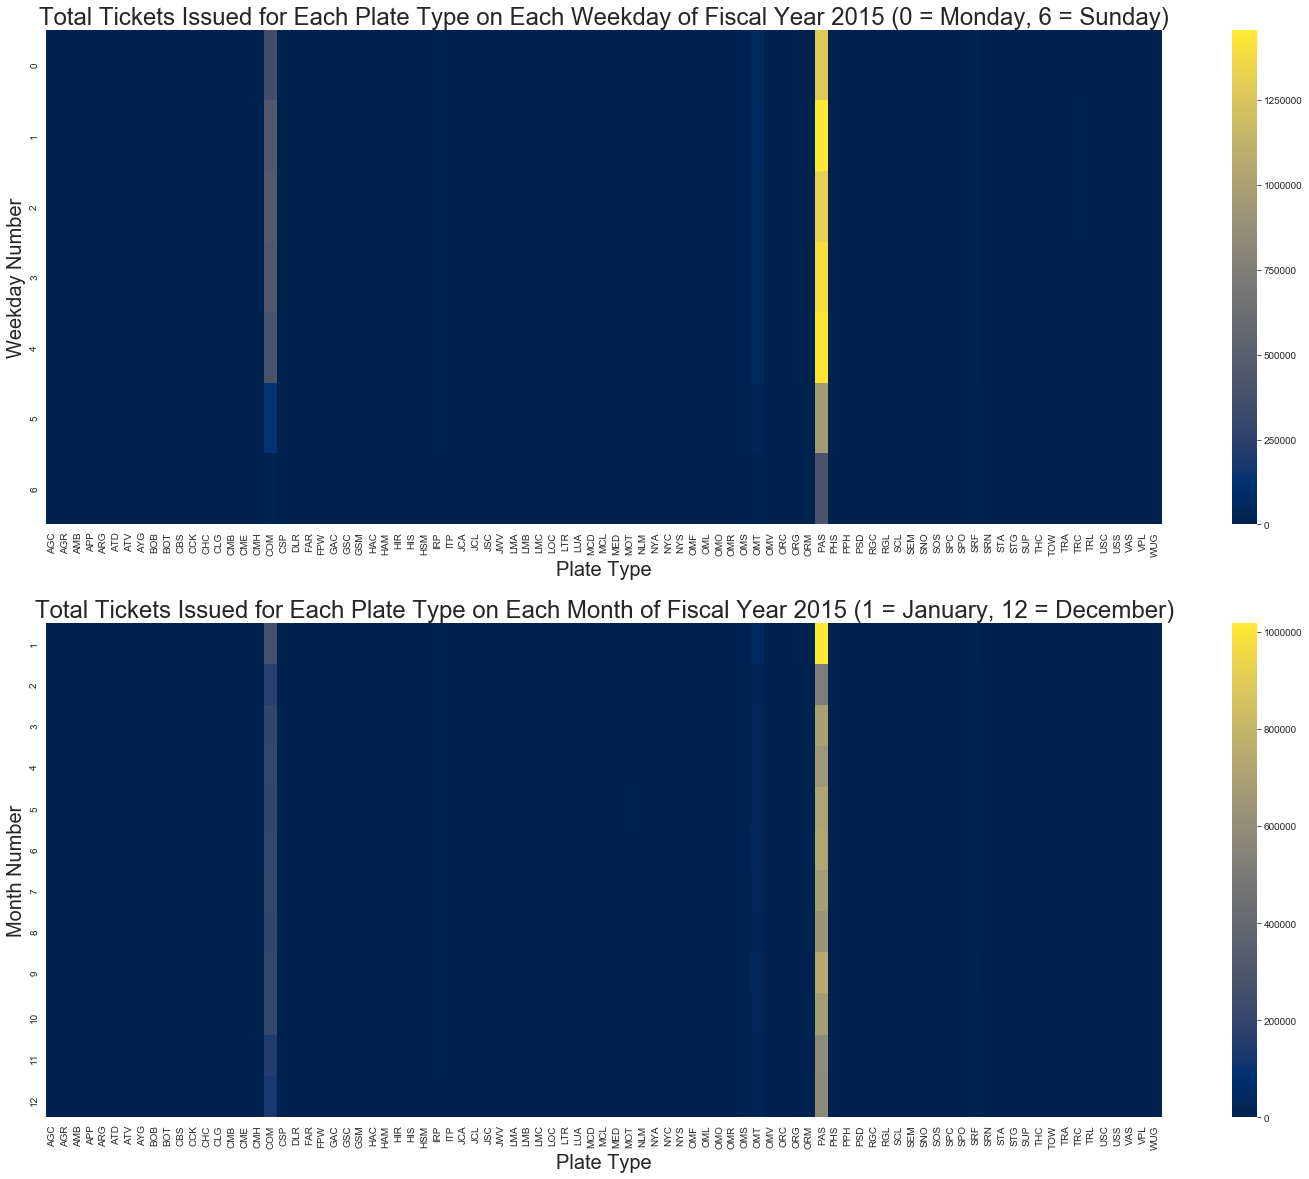

In [8]:
#Create a sub-data set
Date_PT_TotalTX = raw_data[['Issue Date','Plate Type','Summons Number']]
# Fill any N/A with number string "N/A"
Date_PT_TotalTX = Date_PT_TotalTX.fillna("not_valid")
#group by data base on Issue Date and Plate Type
Date_PT_TotalTX = Date_PT_TotalTX.groupby(['Issue Date','Plate Type'], as_index = False).count()
# Cast the entries of the Issue Date column to datetime objects and set them as index
Date_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_PT_TotalTX['Issue Date'])
Date_PT_TotalTX = Date_PT_TotalTX.set_index('Issue Date')
#Select the tickets issued inside the fisical year range
Date_PT_TotalTX = Date_PT_TotalTX.loc[start_date:end_date]
#drop the rows with plate type 999, since it cannot be categorized base on NYC DOT wbesite
Date_PT_TotalTX = Date_PT_TotalTX.loc[Date_PT_TotalTX['Plate Type'] != '999']
#get month number and weekday from each Issue Date and assign them to a new column
Date_PT_TotalTX['Month Number'] = Date_PT_TotalTX.index.month
Date_PT_TotalTX['Weekday Number'] = Date_PT_TotalTX.index.weekday
#Get total tickets issued for each plate type in each month
Weekday_PT_TotalTX = Date_PT_TotalTX.groupby(['Weekday Number', 'Plate Type']).sum()
Month_PT_TotalTX = Date_PT_TotalTX.groupby(['Month Number','Plate Type']).sum()
#Tranform the table for heat plot
Weekday_PT_TotalTX = Weekday_PT_TotalTX.reset_index()
Month_PT_TotalTX = Month_PT_TotalTX.reset_index()
Weekday_PT_TotalTX = Weekday_PT_TotalTX.pivot(index = 'Weekday Number', columns = 'Plate Type', values = 'Summons Number')
Weekday_PT_TotalTX = Weekday_PT_TotalTX.fillna(0)
Month_PT_TotalTX = Month_PT_TotalTX.pivot(index='Month Number', columns='Plate Type', values='Summons Number')
Month_PT_TotalTX = Month_PT_TotalTX.fillna(0)

#Making Heatmap
fig3, axes = plt.subplots(2,1, figsize=(25,20)) 
sns.heatmap(ax = axes[0], data = Weekday_PT_TotalTX, cmap = "cividis")
axes[0].set_title("Total Tickets Issued for Each Plate Type on Each Weekday of Fiscal Year " + str(year) + " (0 = Monday, 6 = Sunday)",fontsize = 24)
axes[0].set_xlabel("Plate Type", fontsize = 20)
axes[0].set_ylabel("Weekday Number", fontsize = 20)
sns.heatmap(ax = axes[1], data = Month_PT_TotalTX, cmap = "cividis")
axes[1].set_title("Total Tickets Issued for Each Plate Type on Each Month of Fiscal Year " + str(year) + " (1 = January, 12 = December)",fontsize = 24 )
axes[1].set_xlabel("Plate Type", fontsize = 20)
axes[1].set_ylabel("Month Number", fontsize = 20)

### 5. violation code with Plate Types

In [9]:
#Create a sub-data set
Date_VCode_PT_TotalTX = raw_data[['Issue Date','Violation Code','Plate Type','Summons Number']]
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.fillna("not_valid") 
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.groupby(['Issue Date','Plate Type','Violation Code'], as_index = False).count()
Date_VCode_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_VCode_PT_TotalTX['Issue Date'])
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.set_index('Issue Date')
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[start_date:end_date]
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[Date_VCode_PT_TotalTX['Plate Type'] != '999']
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[Date_VCode_PT_TotalTX['Violation Code'] != 0]

VCode_PT_TotalTX = Date_VCode_PT_TotalTX.groupby(['Violation Code', 'Plate Type']).sum().reset_index()
VCode_PT_TotalTX = VCode_PT_TotalTX.fillna(0)
VCode_PT_TotalTX = VCode_PT_TotalTX.rename(columns = {'Summons Number' : 'Total Tickets'})

Text(205.0, 0.5, 'Violation Code')

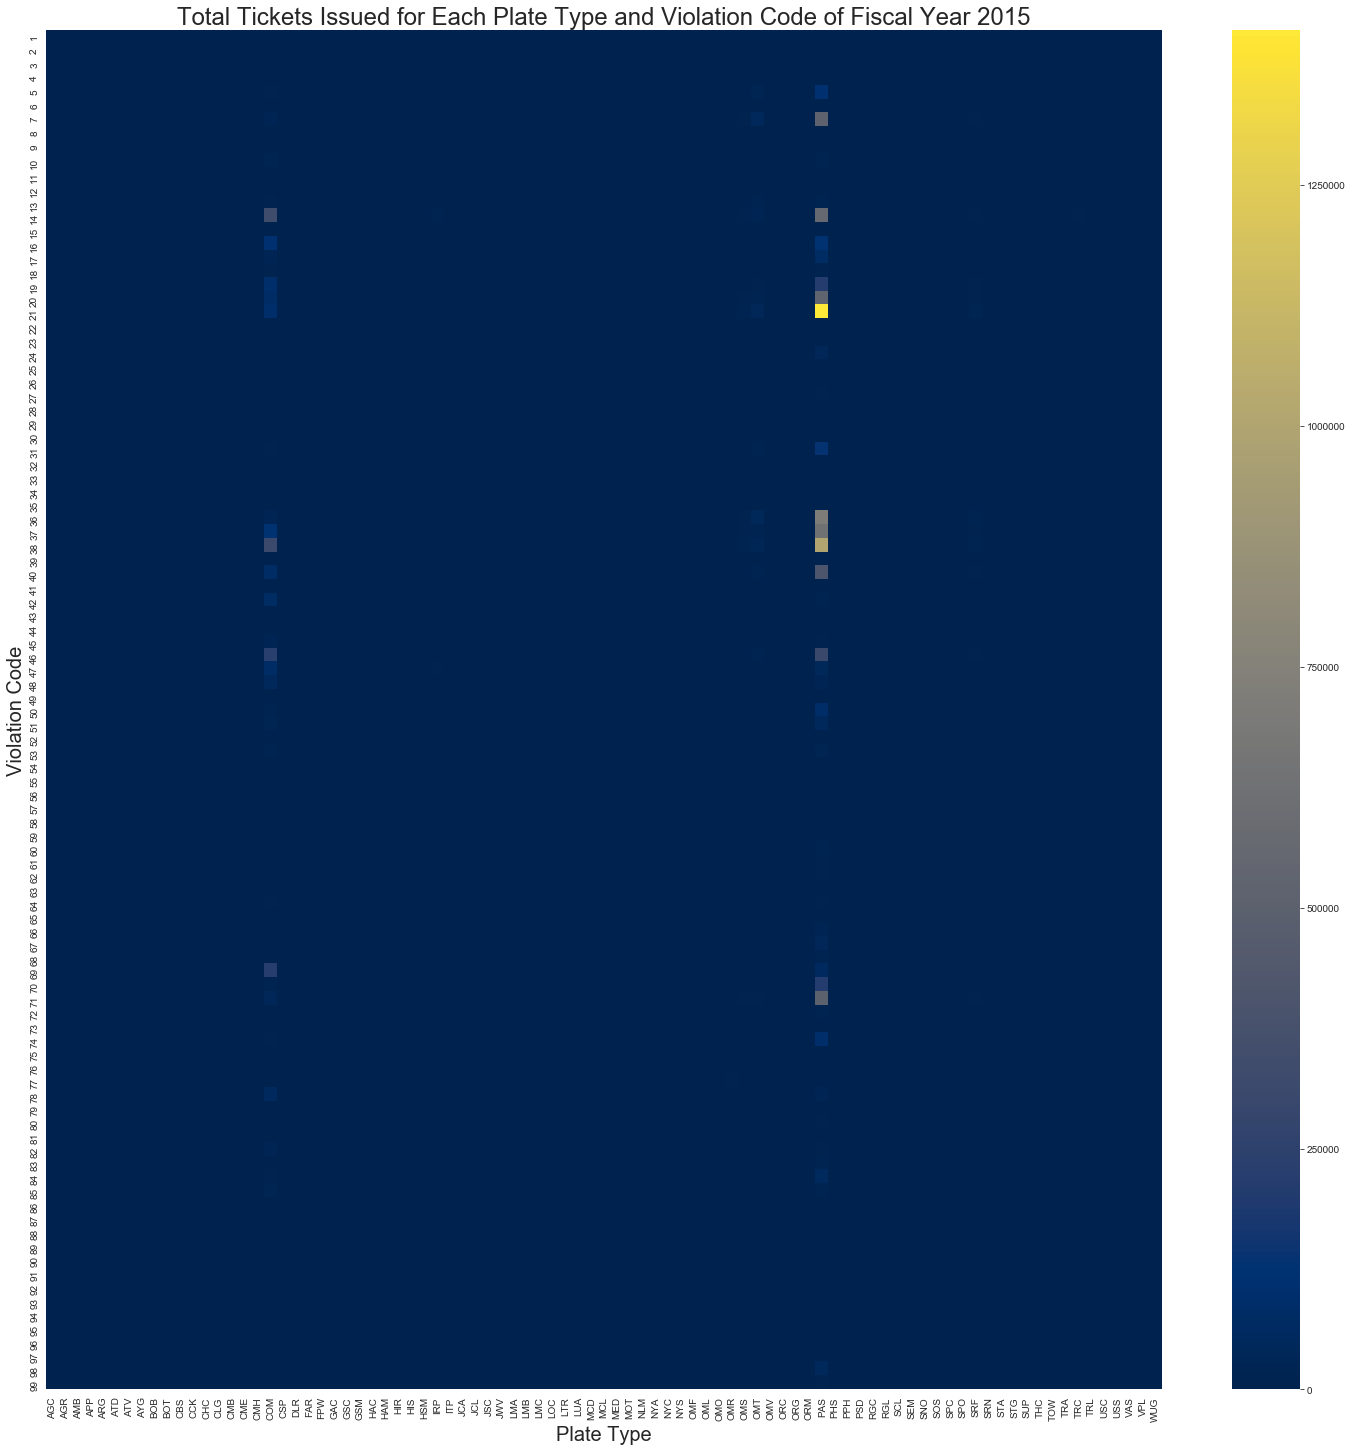

In [10]:
#All violation codes
fig, ax = plt.subplots(1,1, figsize = (25,25))
VCode_PT_TotalTX_all = VCode_PT_TotalTX.pivot(index='Violation Code', columns='Plate Type', values='Total Tickets')
VCode_PT_TotalTX_all = VCode_PT_TotalTX_all.fillna(0)
sns.heatmap(ax = ax, data = VCode_PT_TotalTX_all, cmap = "cividis")
ax.set_title("Total Tickets Issued for Each Plate Type and Violation Code of Fiscal Year " + str(year) ,fontsize = 24)
ax.set_xlabel("Plate Type", fontsize = 20)
ax.set_ylabel("Violation Code", fontsize = 20)

Enter the violation code (1-99): 10


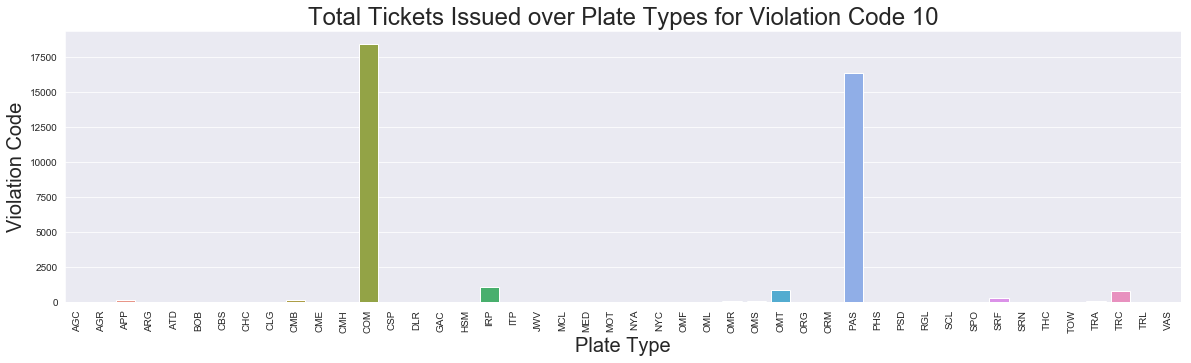

In [17]:
#individual violation code
v_code = input("Enter the violation code (1-99): ")
selected_df = VCode_PT_TotalTX.loc[VCode_PT_TotalTX['Violation Code'] == int(v_code)]
fig, ax = plt.subplots(1,1, figsize = (20,5))
sns.set_style("darkgrid")
sns.barplot(x = 'Plate Type', y = 'Total Tickets', data = selected_df)
ax.set_title("Total Tickets Issued over Plate Types for Violation Code " + str(v_code) ,fontsize = 24)
ax.set_xlabel("Plate Type", fontsize = 20)
ax.set_ylabel("Violation Code", fontsize = 20)
ax = ax.set_xticklabels(selected_df['Plate Type'], rotation=90, ha = 'center')

#### 5. Total Tickets Issued by Each Precinct of NYC 

Text(0.5, 1.0, 'Total Tickets Issued by Each Precinct of NYC in Fiscal Year 2015')

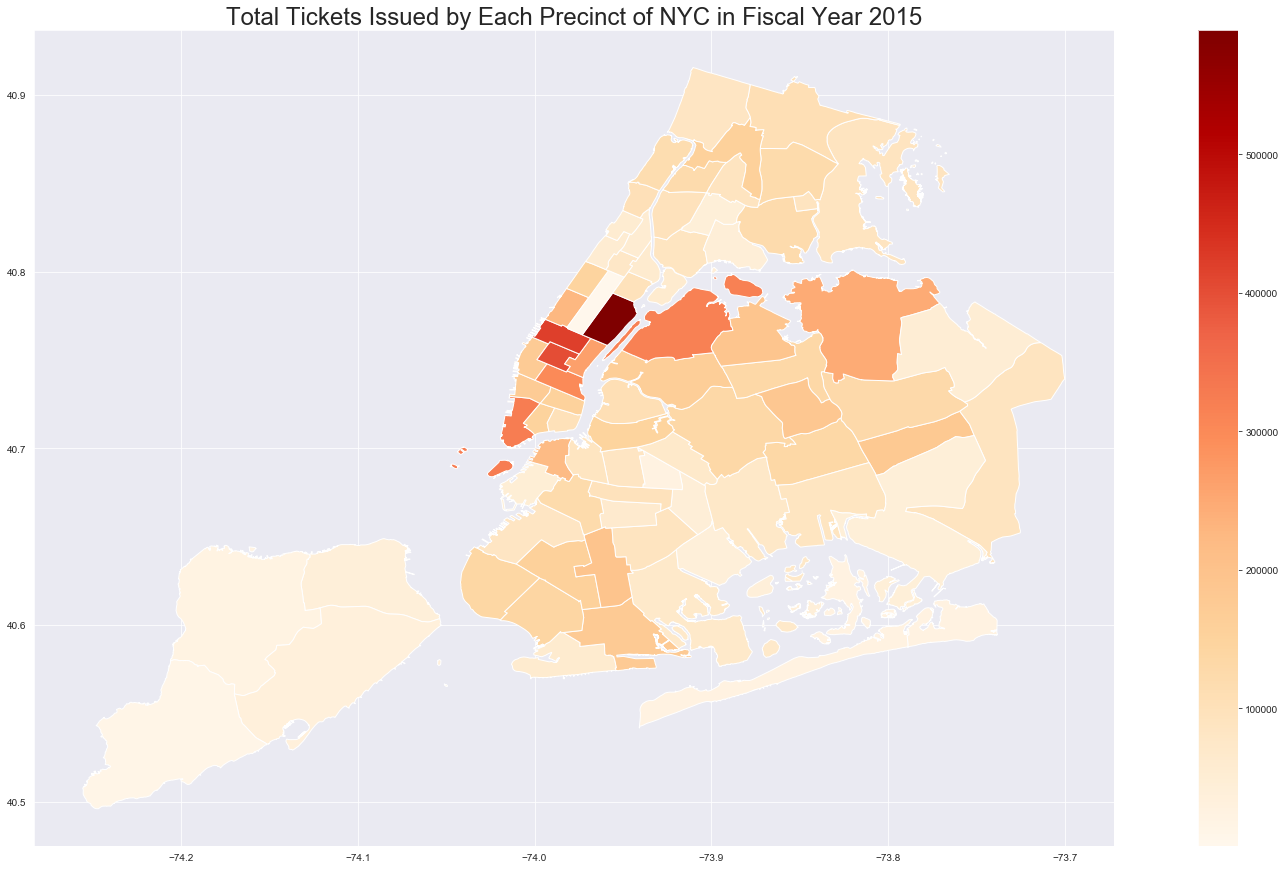

In [18]:
Date_Precinct_TotalTX = raw_data[['Issue Date','Violation Precinct','Summons Number']]
#Group data based on issue date and precinct
Date_Precinct_TotalTX = Date_Precinct_TotalTX.groupby(['Issue Date','Violation Precinct'], as_index = False).count()
Date_Precinct_TotalTX['Issue Date'] = pd.to_datetime(Date_Precinct_TotalTX['Issue Date'])
Date_Precinct_TotalTX = Date_Precinct_TotalTX.set_index('Issue Date')
#locate data within the approporiate fiscal year range
Date_Precinct_TotalTX = Date_Precinct_TotalTX[start_date:end_date]
#Group data base on precinct
Precinct_TotalTX = Date_Precinct_TotalTX.groupby('Violation Precinct').sum()
#remove invalid precinct entries
Precinct_TotalTX = Precinct_TotalTX[1:124]
Precinct_TotalTX = Precinct_TotalTX.drop([2,3,4,8,11,12,15,16,21,27,29,31,35,36,37,38,39,51,53,54,55,56,57,58,59,64,65,74,80,82,85,86,87,89,91,92,93,95,96,97,98,99,116,117,118,119])

#Precinct Heat Map
map_path = "./precinct_map/geo_export_1ac7dc26-ca74-4ae0-8bef-28d6099c5e96.shp"
data = gpd.read_file(map_path)
data = data.set_index('precinct')
data = pd.concat([data,Precinct_TotalTX], axis = 1)
fig, ax = plt.subplots(1, 1, figsize = (30,15))
data.plot(column='Summons Number', legend=True, ax = ax, cmap = 'OrRd')
ax.set_title("Total Tickets Issued by Each Precinct of NYC in Fiscal Year " + str(year), Fontsize = 24)